In [ ]:
import pandas as pd

df = pd.read_csv("nagpur_public_transport_crowd_data.csv")

df.head()



,vehicle_id,route_id,stop_id,timestamp,ticket_count,capacity,day_type,time_slot,occupancy_percentage,crowd_level
0,BUS_NGP_149,R_NGP_03,Sitabuldi,20-01-2026 19:48,38,40,Weekday,Evening,95,HIGH
1,BUS_NGP_008,R_NGP_21,Wadi,16-01-2026 06:52,12,40,Weekday,Morning,30,LOW
2,BUS_NGP_023,R_NGP_03,Sitabuldi,06-01-2026 08:53,31,50,Weekday,Morning,62,MEDIUM
3,BUS_NGP_057,R_NGP_03,Ajni,06-01-2026 15:48,12,50,Weekday,Afternoon,24,LOW
4,BUS_NGP_004,R_NGP_12,Reshimbagh,29-01-2026 22:26,23,45,Weekday,Night,51,MEDIUM


In [ ]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   vehicle_id            4000 non-null   object
 1   route_id              4000 non-null   object
 2   stop_id               4000 non-null   object
 3   timestamp             4000 non-null   object
 4   ticket_count          4000 non-null   int64 
 5   capacity              4000 non-null   int64 
 6   day_type              4000 non-null   object
 7   time_slot             4000 non-null   object
 8   occupancy_percentage  4000 non-null   int64 
 9   crowd_level           4000 non-null   object
dtypes: int64(3), object(7)
memory usage: 312.6+ KB


,0
vehicle_id,0
route_id,0
stop_id,0
timestamp,0
ticket_count,0
capacity,0
day_type,0
time_slot,0
occupancy_percentage,0
crowd_level,0


In [ ]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour
df["weekday"] = df["timestamp"].dt.weekday
df.drop(columns=["timestamp"], inplace=True)

/tmp/ipython-input-3301952175.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"])


In [ ]:
import random

def soften_label(row):
    if row["crowd_level"] == "HIGH" and random.random() < 0.15:
        return "MEDIUM"
    if row["crowd_level"] == "MEDIUM" and random.random() < 0.15:
        return random.choice(["LOW", "HIGH"])
    if row["crowd_level"] == "LOW" and random.random() < 0.15:
        return "MEDIUM"
    return row["crowd_level"]

df["crowd_level"] = df.apply(soften_label, axis=1)


In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ["vehicle_id", "route_id", "stop_id", "day_type"]

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df["crowd_level"] = LabelEncoder().fit_transform(df["crowd_level"])


In [ ]:
X = df.drop(
    ["crowd_level", "occupancy_percentage", "time_slot"],
    axis=1
)
y = df["crowd_level"]

print(X.columns)


Index(['vehicle_id', 'route_id', 'stop_id', 'ticket_count', 'capacity',
       'day_type', 'hour', 'weekday'],
      dtype='object')


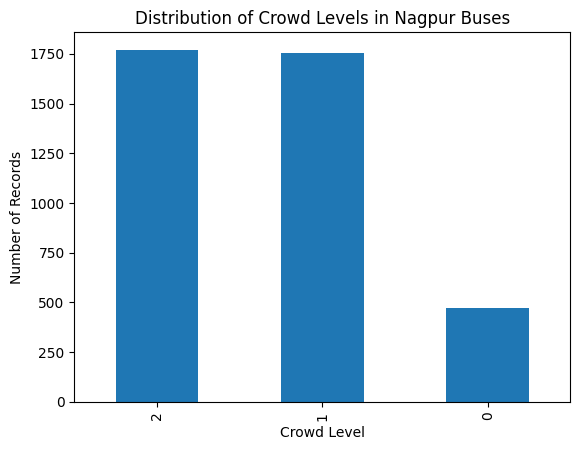

In [ ]:
import matplotlib.pyplot as plt

df["crowd_level"].value_counts().plot(kind="bar")
plt.title("Distribution of Crowd Levels in Nagpur Buses")
plt.xlabel("Crowd Level")
plt.ylabel("Number of Records")
plt.show()


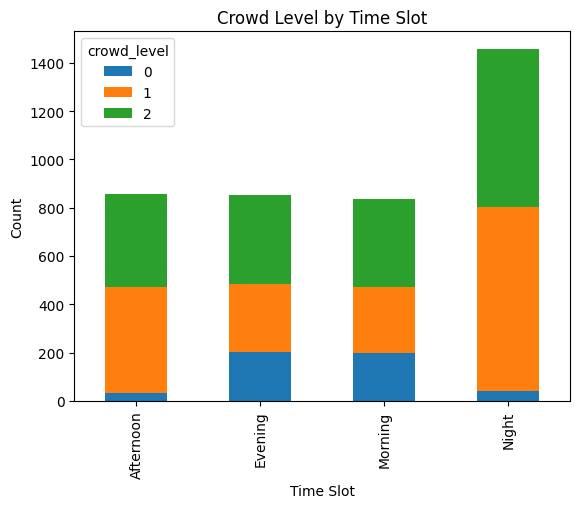

In [ ]:
pd.crosstab(df["time_slot"], df["crowd_level"]).plot(kind="bar", stacked=True)
plt.title("Crowd Level by Time Slot")
plt.xlabel("Time Slot")
plt.ylabel("Count")
plt.show()


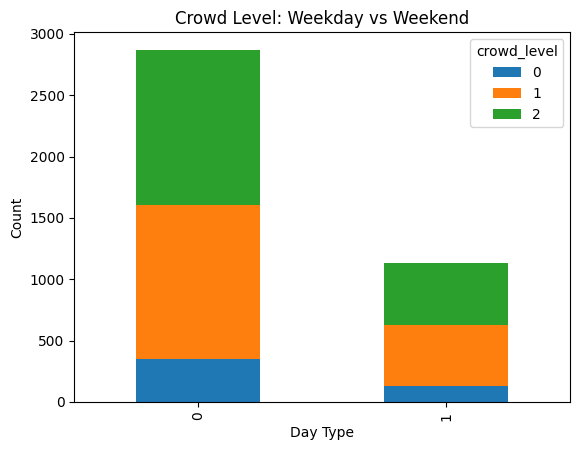

In [ ]:
pd.crosstab(df["day_type"], df["crowd_level"]).plot(kind="bar", stacked=True)
plt.title("Crowd Level: Weekday vs Weekend")
plt.xlabel("Day Type")
plt.ylabel("Count")
plt.show()


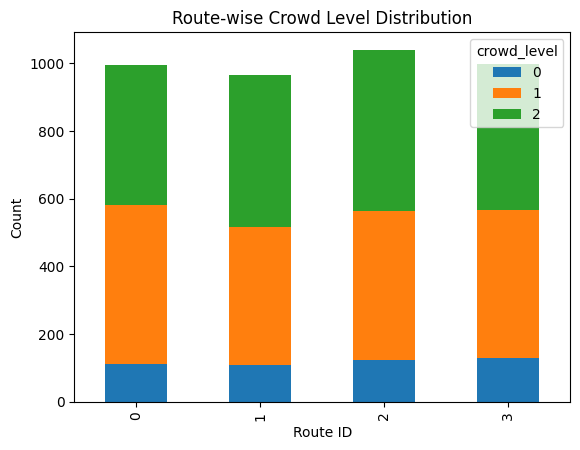

In [ ]:
pd.crosstab(df["route_id"], df["crowd_level"]).plot(kind="bar", stacked=True)
plt.title("Route-wise Crowd Level Distribution")
plt.xlabel("Route ID")
plt.ylabel("Count")
plt.show()


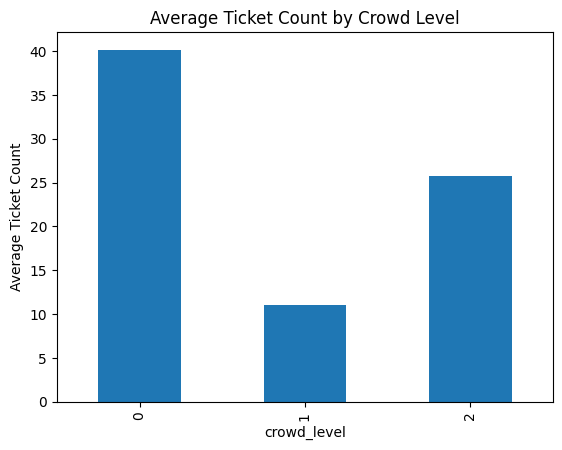

In [ ]:
df.groupby("crowd_level")["ticket_count"].mean().plot(kind="bar")
plt.title("Average Ticket Count by Crowd Level")
plt.ylabel("Average Ticket Count")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=14,
    class_weight={0: 1, 1: 1, 2: 2},  # HIGH crowd weighted more
    random_state=42
)
model.fit(X_train, y_train)



RandomForestClassifier(class_weight={0: 1, 1: 1, 2: 2}, max_depth=14,
                       n_estimators=300, random_state=42)

In [ ]:
y_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.78      0.62      0.69        90
           1       0.84      0.89      0.87       365
           2       0.79      0.78      0.78       345

    accuracy                           0.81       800
   macro avg       0.80      0.76      0.78       800
weighted avg       0.81      0.81      0.81       800



In [ ]:
import joblib

joblib.dump(model, "nagpur_crowd_model.pkl")


['nagpur_crowd_model.pkl']

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)


In [ ]:
gb_model.fit(X_train, y_train)



GradientBoostingClassifier(n_estimators=150, random_state=42)

In [ ]:
gb_pred = gb_model.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, gb_pred))


              precision    recall  f1-score   support

           0       0.79      0.70      0.74        90
           1       0.84      0.91      0.88       365
           2       0.82      0.77      0.79       345

    accuracy                           0.83       800
   macro avg       0.82      0.79      0.80       800
weighted avg       0.82      0.83      0.82       800



In [ ]:
import joblib
joblib.dump(model, "final_nagpur_crowd_model.pkl")


['final_nagpur_crowd_model.pkl']

In [ ]:
print("Random Forest Results")
print(classification_report(y_test, y_pred))

print("Gradient Boosting Results")
print(classification_report(y_test, gb_pred))


Random Forest Results
              precision    recall  f1-score   support

           0       0.78      0.62      0.69        90
           1       0.84      0.89      0.87       365
           2       0.79      0.78      0.78       345

    accuracy                           0.81       800
   macro avg       0.80      0.76      0.78       800
weighted avg       0.81      0.81      0.81       800

Gradient Boosting Results
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        90
           1       0.84      0.91      0.88       365
           2       0.82      0.77      0.79       345

    accuracy                           0.83       800
   macro avg       0.82      0.79      0.80       800
weighted avg       0.82      0.83      0.82       800



In [ ]:
import joblib
model = joblib.load("final_nagpur_crowd_model.pkl")

In [ ]:
live_input ={
    "vehicle_id":102,
    "route_id": 3,
    "stop_id": 7,
    "ticket_count": 38,
    "capacity": 50,
    "day_type": 0,
    "hour": 18,
    "weekday": 1
}

In [ ]:
live_df = pd.DataFrame([live_input])

In [ ]:
prediction = model.predict(live_df)[0]

crowd_map = {
    0: "LOW",
    1: "MEDIUM",
    2: "HIGH"
}

predicted_crowd = crowd_map[prediction]
print("Predicted Crowd Level:", predicted_crowd)



Predicted Crowd Level: LOW


In [ ]:
occupancy_percentage = (live_input["ticket_count"] / live_input["capacity"]) * 100
occupancy_percentage = round(occupancy_percentage, 2)


In [ ]:
if predicted_crowd == "HIGH" and occupancy_percentage > 80:
    alert = "Overcrowding risk detected"
elif predicted_crowd == "MEDIUM":
    alert = "Moderate crowd, monitor closely"
else:
    alert = "Crowd level normal"


In [ ]:
output = {
    "vehicle_id": live_input["vehicle_id"],
    "route_id": live_input["route_id"],
    "predicted_crowd_level": predicted_crowd,
    "occupancy_percentage": occupancy_percentage,
    "alert": alert
}

output


{'vehicle_id': 102,
 'route_id': 3,
 'predicted_crowd_level': 'LOW',
 'occupancy_percentage': 76.0,
 'alert': 'Crowd level normal'}